# REZ capacity factors

- Compare mean capacity factors computed with BARRA-C2 with those computed with ERA5 and AEMO's published data

In [66]:
client.close()
cluster.close()

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=48:mem=179GB


In [2]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
PROJECT = "dt6"

In [67]:
walltime = "01:00:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P "+PROJECT,
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/xp65+gdata/w42+scratch/w42+gdata/gb02+scratch/gb02+gdata/ng72+scratch/ng72+gdata/rt52"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=48:mem=179GB
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38963 instead
  warnings.warn(
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-3297799' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-3303648' coro=<Client._gather.<locals>.wait() done

In [68]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=48:mem=179GB


In [69]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/38963/status,
Dashboard: /proxy/38963/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.3:39915,Workers: 0
Dashboard: /proxy/38963/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt

## Load data

BARRA-C2 Capacity factor

In [12]:
cf_paths = sorted(glob.glob("/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/*.zarr"))

In [13]:
cf_paths = cf_paths[32:-1]

In [14]:
datasets = [xr.open_zarr(p, chunks={}) for p in cf_paths]

In [15]:
cf_barra = xr.combine_by_coords(datasets, compat="override", data_vars="minimal", coords="minimal")

In [16]:
cf_barra = cf_barra.cf100m

In [17]:
cf_barra

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

REZ mask

In [8]:
rez_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_BARRA-C2_grid.nc"
)["REZ"]

Wind farms

- From Palmer et al (2025): https://www.publish.csiro.au/es/fulltext/ES24028
- Thanks to Rachael Isphording for retrieving the paper's data

In [14]:
# aemc_farms = pd.read_csv(
#     "/g/data/ng72/ri9247/data/working_wind_farm_locations_AEMC_16Sept2025.csv",
#     index_col=0
# )

In [15]:
# aemc_farms[aemc_farms["Regcap"] > 0].head()

In [16]:
# r = pd.read_csv(
#     "/g/data/ng72/ri9247/data/rez_metadata.csv",
#     index_col=0
# )

### Analysis

In [17]:
def compute_rez_means(cf_da, sampling_frequency="20min"):
    """
    Compute the REZ mean capacity factor.
    Option to only select every X time steps - assumes 20min input data, and X-hourly data will select
     each time step that coincides with the hour (not 20mins past etc.).

    cf_da: array, capacity factors
    sampling_frequency: str, "20min" or "Xhr", where X indicates every X-hourly time step
    """
    if sampling_frequency == "20min":
        skip = None
    elif sampling_frequency[-2:] == "hr":
        skip = int(sampling_frequency[:-2]) * 3 # *3 because assumes 20min input data and 0000 first timestep
    else:
        raise ValueError("Incorrect sampling_frequency specified")

    # Set up empty DataFrame
    rez_means = pd.DataFrame(index=rez_mask.region.values, columns=["raw_mean", "raw_weighted_mean"])
    
    # Select desired time steps
    cf_da = cf_da.sel(time=slice(None, None, skip))
    
    # Loop through REZs and compute mean
    for r in rez_means.index[:]:
        # Select REZ grid cells
        r_cf = cf_da.where(rez_mask.sel(region=r), drop=True)

        # Time-mean (used for arithmetic and weighted means
        r_cf_timemean = r_cf.mean("time", skipna=True).persist()
        
        # Arithmetic mean
        rez_means.loc[r, "raw_mean"] = r_cf_timemean.mean().values

        # Weighted mean
        r_cf_weighted = r_cf.weighted(r_cf_timemean.fillna(0))
        rez_means.loc[r, "raw_weighted_mean"] = r_cf_weighted.mean().values
        
    # Write the capacity factor stats to file
    rez_means.to_csv(
        "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_"+sampling_frequency+".csv"
    )

REZ-mean for 20min data

In [18]:
compute = False

In [19]:
%%time
if compute:
    compute_rez_means(cf_barra, "20min")
rez_means_barra_20m = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_20min.csv",
    index_col=0
)

CPU times: user 2.69 ms, sys: 362 μs, total: 3.06 ms
Wall time: 3.42 ms


REZ-mean for 1hr data (just select each 20-min timestep on the hour)

In [20]:
if compute:
    compute_rez_means(cf_barra, "1hr")
rez_means_barra_1hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_1hr.csv",
    index_col=0
)

REZ-mean for 12hr data

In [21]:
if compute:
    compute_rez_means(cf_barra, "12hr")
rez_means_barra_12hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_12hr.csv",
    index_col=0
)

REZ-mean for 24hr data

In [22]:
# compute = True

In [23]:
if compute:
    compute_rez_means(cf_barra, "24hr")
rez_means_barra_24hr = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_24hr.csv",
    index_col=0
)

REZ-mean for 1-week (168 hours) data

In [24]:
168 * 3

504

In [25]:
if compute:
    compute_rez_means(cf_barra, "168hr")
rez_means_barra_1wk = pd.read_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023_168hr.csv",
    index_col=0
)

Load AEMO and ERA5 stats

In [26]:
# Load AEMO obs and ERA5 REZ stats
cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel/bias_corrected/"

rez_means_era5_aemo = pd.read_csv(
    cf_path + "wind_medium_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
    index_col=0
)

Text(0.5, 0, 'REZ')

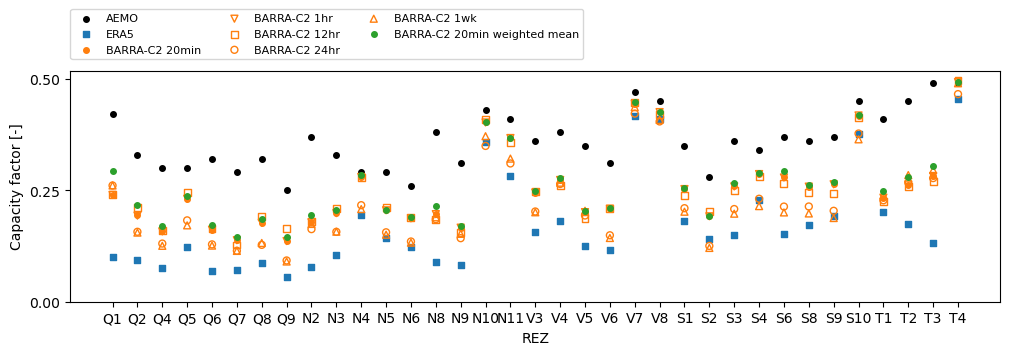

In [24]:
fig, ax = plt.subplots(figsize=(12,3))
s = 16
ylim = 0.5

rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
rez_means_era5_aemo.reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="ERA5")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:orange", s=s, marker="o", label="BARRA-C2 20min")
rez_means_barra_1hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="v", label="BARRA-C2 1hr")
rez_means_barra_12hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="s", label="BARRA-C2 12hr")
rez_means_barra_24hr.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="o", label="BARRA-C2 24hr")
rez_means_barra_1wk.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", c="none", edgecolor="tab:orange", s=s+9, marker="^", label="BARRA-C2 1wk")

rez_means_barra_20m.loc[rez_means_era5_aemo.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_weighted_mean", color="tab:green", s=s, marker="o", label="BARRA-C2 20min weighted mean")

ax.legend(ncols=3, fontsize=8, loc=(0, 1.05))
ax.set_yticks([0, ylim/2, ylim])
ax.set_ylabel("Capacity factor [-]")
ax.set_xlabel("REZ")

#### Spatial variability

In [25]:
def rez_time_mean(rez):
    """
    Return time-mean of capacity factors for a REZ
    
    rez: str, REZ e.g. 'Q1'
    """
    return cf.where(rez_mask.sel(region=rez), drop=True).mean("time")

In [70]:
q1_mean = rez_time_mean("Q1").compute()

In [96]:
n3_mean = rez_time_mean("N3").compute()

In [71]:
v8_mean = rez_time_mean("V8").compute()

In [97]:
s6_mean = rez_time_mean("S6").compute()

In [98]:
t3_mean = rez_time_mean("T3").compute()

In [132]:
def find_cf_threshold(rez, rez_mean_da):
    """
    Find the smallest capacity factor threshold such that mean of rez_mean_da is equal to AEMO's capacity factor
    
    rez: str, REZ e.g. 'Q1'
    rez_mean_da: DataArray, average capacity factors with dimensions lat, lon
    """
    thresholds = np.arange(0, 1.01, 0.01)
    target = rez_means_era5_aemo.loc[rez]["obs_mean"] - 0.1
    
    i = 0
    t = 0
    all_rez_mean = np.round(rez_mean_da.mean().values, 2)
    # print(all_rez_mean)
    while all_rez_mean < target:
        i += 1
        t = thresholds[i]
        all_rez_mean = np.round(rez_mean_da.where(rez_mean_da >= t).mean().values, 2)
        # print(t, all_rez_mean)
        
    return t, all_rez_mean

In [133]:
q1_thresh, q1_thresh_mean = find_cf_threshold("Q1", q1_mean)
print(q1_thresh, q1_thresh_mean)

0.23 0.33


In [134]:
n3_thresh, n3_thresh_mean = find_cf_threshold("N3", n3_mean)
print(n3_thresh, n3_thresh_mean)

0.2 0.23


In [135]:
v8_thresh, v8_thresh_mean = find_cf_threshold("V8", v8_mean)
print(v8_thresh, v8_thresh_mean)

0 0.43


In [136]:
s6_thresh, s6_thresh_mean = find_cf_threshold("S6", s6_mean)
print(s6_thresh, s6_thresh_mean)

0 0.28


In [137]:
t3_thresh, t3_thresh_mean = find_cf_threshold("T3", t3_mean)
print(t3_thresh, t3_thresh_mean)

0.36 0.4


In [147]:
def plot_rez_thresh(rez, rez_time_mean, rez_thresh, rez_thresh_mean):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    p = rez_time_mean.plot(ax=ax[0])
    ax[0].set_title("REZ mean: "+str(np.round(rez_time_mean.mean().values, 2)) + " (AEMO: " + str(rez_means_era5_aemo.loc[rez]["obs_mean"]) + ")")
    cbar = p.colorbar
    vmin = cbar.norm.vmin
    vmax = cbar.norm.vmax
    
    rez_time_mean.where(rez_time_mean >= rez_thresh).plot(ax=ax[1], vmin=vmin, vmax=vmax)
    ax[1].set_title("REZ mean: "+str(rez_thresh_mean) + " (threshold: " + str(rez_thresh) + ")")

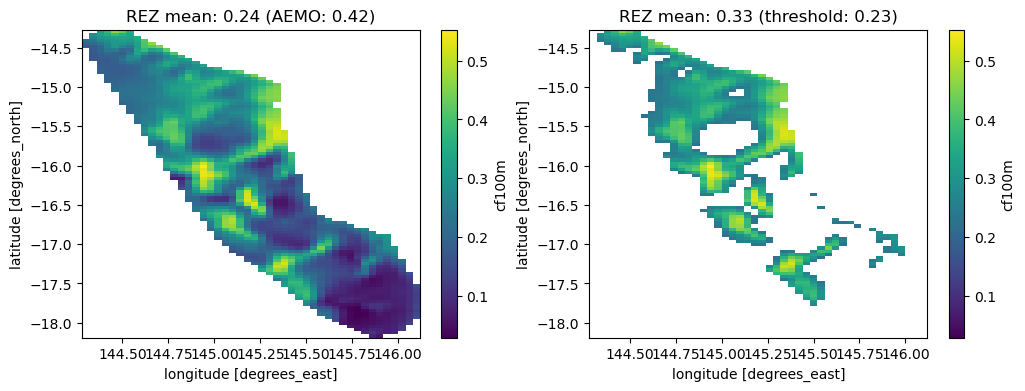

In [148]:
plot_rez_thresh("Q1", q1_mean, q1_thresh, q1_thresh_mean)

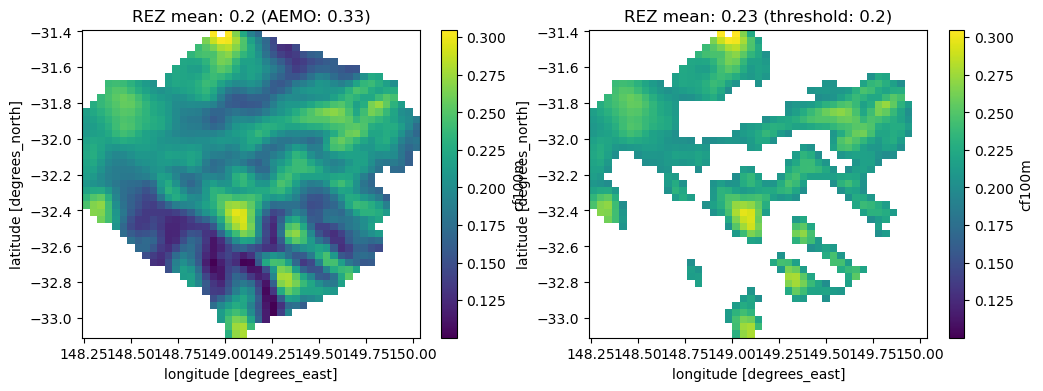

In [149]:
plot_rez_thresh("N3", n3_mean, n3_thresh, n3_thresh_mean)

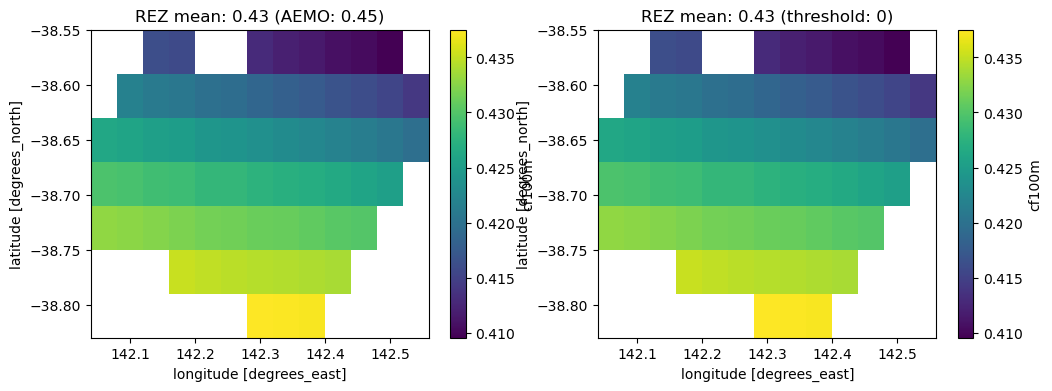

In [150]:
plot_rez_thresh("V8", v8_mean, v8_thresh, v8_thresh_mean)

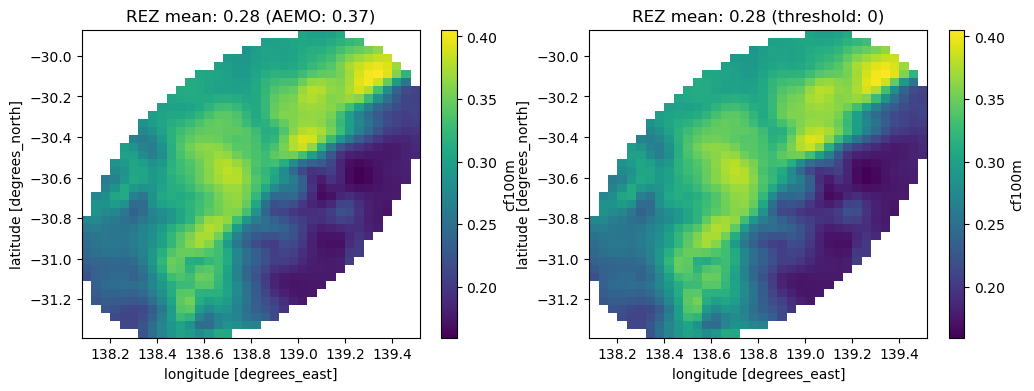

In [151]:
plot_rez_thresh("S6", s6_mean, s6_thresh, s6_thresh_mean)

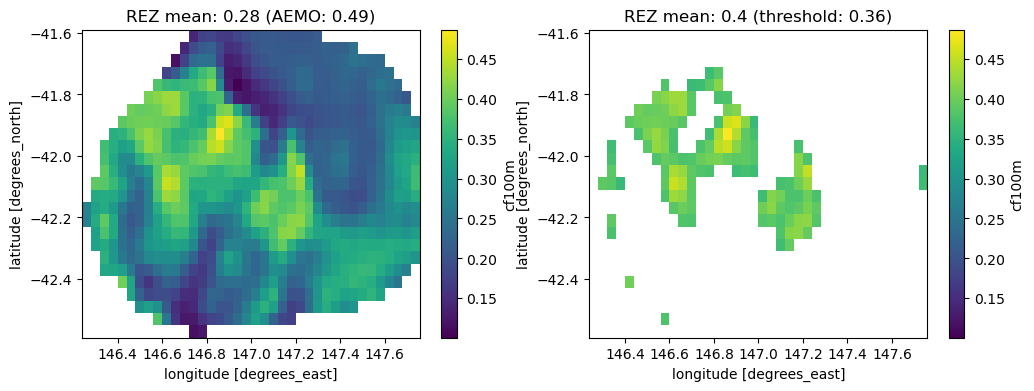

In [152]:
plot_rez_thresh("T3", t3_mean, t3_thresh, t3_thresh_mean)

### Wind droughts - temporal resolution

In [9]:
r1 = "S6"
r2 = "Q1"

In [18]:
s = cf_barra.where(rez_mask.sel(region=r1), drop=True)

In [19]:
q = cf_barra.where(rez_mask.sel(region=r2), drop=True)

In [20]:
s20m = s.mean(["lat", "lon"])
q20m = q.mean(["lat", "lon"])

In [21]:
s1hr = s.sel(time=slice(None, None, 3)).mean(["lat", "lon"])
q1hr = q.sel(time=slice(None, None, 3)).mean(["lat", "lon"])

In [22]:
# s6hr = s.sel(time=slice(None, None, 3*6)).mean(["lat", "lon"])
# q6hr = q.sel(time=slice(None, None, 3*6)).mean(["lat", "lon"])

In [23]:
s12hr = s.sel(time=slice(None, None, 3*12)).mean(["lat", "lon"])
q12hr = q.sel(time=slice(None, None, 3*12)).mean(["lat", "lon"])

In [24]:
s24hr = s.sel(time=slice(None, None, 3*24)).mean(["lat", "lon"])
q24hr = q.sel(time=slice(None, None, 3*24)).mean(["lat", "lon"])

In [25]:
# print(s20m.mean().values, s1hr.mean().values, s12hr.mean().values, s24hr.mean().values)

In [26]:
# fig,ax = plt.subplots()
# _ = ax.hist(s20m, alpha=0.5, density=True)
# _ = ax.hist(s1hr, alpha=0.5, density=True)
# _ = ax.hist(s12hr, alpha=0.5, density=True)
# _ = ax.hist(s24hr, alpha=0.5, density=True)

Compute some rolling mean time series and write to disk

In [92]:
def get_rolling_mean(compute, da, rez, sampling_frequencies, lengths):
    """
    Return rolling mean arrays for desired sampling frequencies and window lengths

    compute: bool, whether to compute or read
    da: array
    rez: str, name of REZ e.g. 'S6'
    sampling_frequencies: list, elements in format '20min' or 'Xhr', where X indicates every X-hourly time step
    lengths: list, elements integers indicating rolling length (in days)
    """
    def _get_skip(t):
        if t == "20min":
            nhrs = 0.33
            skip = None
            hr_time_steps = 24 * 3
        elif t[-2:] == "hr":
            nhrs = int(t[:-2])
            skip = nhrs * 3 # *3 because assumes 20min input data and 0000 first timestep
            hr_time_steps = 24 / nhrs # number of time steps per hour
        else:
            raise ValueError("Incorrect t specified")
        return nhrs, skip, hr_time_steps

    # Get REZ-mean data
    da = da.where(rez_mask.sel(region=rez), drop=True)
    da = da.mean(["lat", "lon"])

    # for each sampling frequency get regional-average array and other variables
    sf_list = []
    roll_list = []
    nhrs_list = []
    for sf in sampling_frequencies:
        _nhr, _skip, _hr_ts = _get_skip(sf)
        
        sf_list.append(da.sel(time=slice(None, None, _skip)))
        roll_list.append(_hr_ts)
        nhrs_list.append(_nhr)
        

    return_list = []
    # For each window length...
    for l in lengths:
        
        len_list = []
        # For each sampling frequency, rolling window and hours-per-timestep
        for (da, roll, nhr) in zip(
            sf_list,
            roll_list,
            nhrs_list
        ):
            filename = "wind_capacity_factor_REZ_"+r+"_"+str(nhr)+"hr_roll"+str(l)+"day_2011-2023"

            if compute:
                arr = da.chunk({"time": -1}).rolling(time=roll).mean()
                arr = rolling_expand_dim(da, roll)
                arr = arr.to_dataset(name="cf_roll" + str(l) + "day")
                arr.to_netcdf(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + filename + ".nc"
                )
            else:
                arr = xr.open_mfdataset(
                    "/g/data/ng72/dr6273/work/projects/wind_power_comparison/data/" + filename + ".nc"
                )
                return_list.append(arr)
    if compute == False:
        return return_list

In [93]:
x = get_rolling_mean(
    False,
    cf_barra,
    "S6",
    ["20min", "1hr", "12hr", "24hr"],
    [1, 2, 3, 5, 7, 10, 14, 21]
)

In [95]:
len(x)

32

Fix drought length as 3 days (rolling mean of appropriate length for sampling frequency)

In [50]:
s20m_r3day = s20m.rolling(time=3*24*3).mean().compute()

In [53]:
s1hr_r3day = s1hr.rolling(time=24*3).mean().compute()

In [54]:
s12hr_r3day = s12hr.rolling(time=2*3).mean().compute()

In [70]:
# Rolling fails, need to chunk: https://github.com/pydata/xarray/issues/9862
s24hr_r3day = s24hr.chunk({"time": -1}).rolling(time=3).mean().compute()

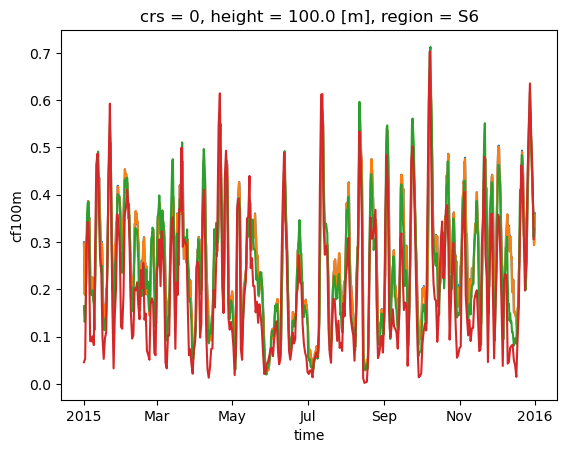

In [77]:
s20m_r3day.sel(time="2015").plot()
s1hr_r3day.sel(time="2015").plot()
s12hr_r3day.sel(time="2015").plot()
s24hr_r3day.sel(time="2015").plot()

Fix drought severity (and length)

In [90]:
# drought threshold
dthresh = 0.2

In [78]:
# drought frequency (proportion of timesteps below threshold)
#  each time step is a 3-day mean, so this is frequency of 3-day droughts

In [89]:
def drought_freq(da, thresh):
    da = da.dropna("time")
    return da.where(da < thresh).count() / len(da.time)

In [92]:
drought_freq(s20m_r3day, dthresh).values

array(0.28232267)

In [93]:
drought_freq(s1hr_r3day, dthresh).values

array(0.28403333)

In [94]:
drought_freq(s12hr_r3day, dthresh).values

array(0.35465178)

In [95]:
drought_freq(s24hr_r3day, dthresh).values

array(0.53876949)

Fix drought frequency (and length)

In [96]:
# drought freq threshold
dfreq = 0.2

In [102]:
def drought_intensity(da, freq):
    da = da.dropna("time")
    return da.where(da < da.quantile(freq, "time")).max("time")

In [103]:
drought_intensity(s20m_r3day, dfreq).values

array(0.16866022)

In [104]:
drought_intensity(s1hr_r3day, dfreq).values

array(0.16802529)

In [105]:
drought_intensity(s12hr_r3day, dfreq).values

array(0.14273421)

In [106]:
drought_intensity(s24hr_r3day, dfreq).values

array(0.0796583)

Fix drought frequency and intensity - can it be done?
What is the drought length that would satisfy a given intensity and frequency?

Repeat for 7 day drought

In [112]:
s20m_r7day = s20m.rolling(time=3*24*7).mean().compute()

In [113]:
s1hr_r7day = s1hr.rolling(time=24*7).mean().compute()

In [114]:
s12hr_r7day = s12hr.rolling(time=2*7).mean().compute()

In [115]:
# Rolling fails, need to chunk: https://github.com/pydata/xarray/issues/9862
s24hr_r7day = s24hr.chunk({"time": -1}).rolling(time=7).mean().compute()

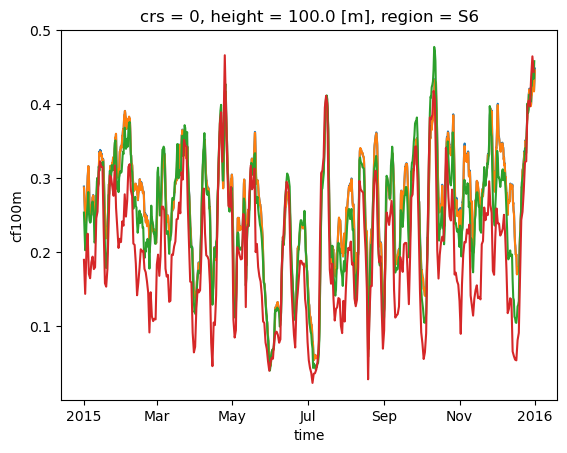

In [116]:
s20m_r7day.sel(time="2015").plot()
s1hr_r7day.sel(time="2015").plot()
s12hr_r7day.sel(time="2015").plot()
s24hr_r7day.sel(time="2015").plot()

Fix drought severity (and length)

In [117]:
# drought threshold
dthresh = 0.2

In [118]:
drought_freq(s20m_r7day, dthresh).values

array(0.18836512)

In [119]:
drought_freq(s1hr_r7day, dthresh).values

array(0.18913741)

In [120]:
drought_freq(s12hr_r7day, dthresh).values

array(0.25181904)

In [121]:
drought_freq(s24hr_r7day, dthresh).values

array(0.48924504)

Fix drought frequency (and length)

In [122]:
# drought freq threshold
dfreq = 0.2

In [123]:
drought_intensity(s20m_r7day, dfreq).values

array(0.20410065)

In [124]:
drought_intensity(s1hr_r7day, dfreq).values

array(0.2036604)

In [125]:
drought_intensity(s12hr_r7day, dfreq).values

array(0.18401632)

In [126]:
drought_intensity(s24hr_r7day, dfreq).values

array(0.12339028)